In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import math

In [4]:
import librosa

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle

In [7]:
import keras

In [8]:
from keras import layers, Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df_path= os.getcwd()+'/drive/MyDrive/Sub_Data/data_13_G.pickle'

In [11]:
df = pd.read_pickle(df_path)
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,Labels
0,27.555986,88.491943,-20.645388,18.461662,-22.876869,26.373840,-7.842380,5.040419,-10.529922,30.722309,8.053223,25.249620,-3.851202,disco
1,21.160398,99.239639,-33.311604,24.493477,-17.089005,25.532211,-5.425315,11.550676,-12.097195,27.441135,0.058880,19.927771,-11.912487,disco
2,-13.337629,112.291656,-48.217140,38.652039,-11.287874,30.100903,-4.544308,16.824894,-15.798969,27.857822,-13.360273,20.098824,-20.572792,disco
3,-40.871708,116.767059,-47.124802,49.234226,-17.217890,37.331268,-0.842096,16.252968,-20.979574,27.505018,-24.680790,19.476368,-18.812157,disco
4,-67.497528,117.398331,-47.275208,47.681198,-16.081495,43.743324,13.473402,14.318071,-27.892868,20.559271,-31.776064,17.269453,-14.578279,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233175,-101.685333,23.818932,0.495472,30.757507,17.166796,16.255051,18.272770,9.566826,11.331477,4.932149,9.956822,12.857517,7.169489,reggae
1233176,-136.458862,21.216267,-1.512686,37.810467,22.128681,20.463276,16.296101,12.380598,18.769466,8.667844,15.075156,15.303005,7.611032,reggae
1233177,-167.509811,25.255136,0.489490,48.138466,27.790737,23.130043,17.280693,13.791199,17.217871,7.926507,13.045273,12.954222,9.367888,reggae
1233178,-152.141953,51.688583,-4.779652,27.629368,14.154837,21.258694,11.772314,17.563957,16.069324,20.217516,16.887005,8.754175,-7.446566,reggae


In [12]:
def process_df(df):
    '''
    Input: dataframe object
    Output: returns a 3d nparray
    '''
    inputs = df.iloc[0*130:0+1*130,:-1] #getting the first 130 rows
    inputs = np.expand_dims(inputs,0)   #expanding the shape of the array by inserting a new axis at the first position
    targets= [df.iloc[0*130,-1]]
    for i in range(1, int(df.shape[0]/130)): #repeating the above process for the entirety of the remaining dataset
        dummy_x = df.iloc[i*130:(i+1)*130, :-1].values
        dummy_x = np.expand_dims(dummy_x,0)
        dummy_y = df.iloc[i*130,-1]
        inputs = np.concatenate((inputs, dummy_x), axis=0)
        targets.append(dummy_y)
    return inputs, targets

In [13]:
def split_data(df, test_size, validation_size):
    '''
    Input: A dataframe
    Ouput: return the train, test and validation set 
    '''
    # inputs, targets = process_df(df)
    # encoder = LabelEncoder()
    # targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 

    #Splitting data into train and test sets
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = test_size)

    #Splitting train data into train and validation sets
    inputs_train, inputs_validation, targets_train, targets_validation = train_test_split(inputs_train, targets_train, test_size = validation_size)

    #adding an axis to input sets
    inputs_train = np.expand_dims(inputs_train,-1)
    inputs_validation = np.expand_dims(inputs_validation,-1)
    inputs_test = np.expand_dims(inputs_test,-1)

    return inputs_train, inputs_validation, inputs_test, targets_train, targets_validation, targets_test


In [14]:
def build_model(input_shape):
    '''Generates CNN model'''

    #build network topology
    model = keras.Sequential()

    #1st convolutional layer
    model.add(keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #2st convolutional layer
    model.add(keras.layers.Conv2D(32,(3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((3,3), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #3rd convolutional layer
    model.add(keras.layers.Conv2D(32,(2,2), activation ='relu'))
    model.add(keras.layers.MaxPooling2D((2,2), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [15]:
if __name__ == '__main__':
    inputs, targets = process_df(df)
    encoder = LabelEncoder()
    targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 

    #get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(df, 0.25,0.2)
    print(f'Shape of X_train: {X_train.shape}')
    print(f'Shape of X_train: {X_validation.shape}')
    print(f'Shape of X_train: {X_test.shape}')

    #create network 
    input_shape = (X_train.shape[1], X_train.shape[2],1)
    model = build_model(input_shape)

    #compile model
    optimiser = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimiser, 
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    model.summary()

    #train modle
    history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), batch_size=32,  epochs = 50)

Shape of X_train: (5691, 130, 13, 1)
Shape of X_train: (1423, 130, 13, 1)
Shape of X_train: (2372, 130, 13, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
___________

In [24]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(10,10))
        

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy",color='b')
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy",color='r')
    axs[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="loss",color='b')
    axs[1].plot(history.history["val_loss"], label="validation loss",color='r')
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})
    axs[1].set_title("Loss eval")
    fig.tight_layout(pad=3.0)
    plt.savefig('CNN_train_validation_accuracy.png')
    plt.show()
    



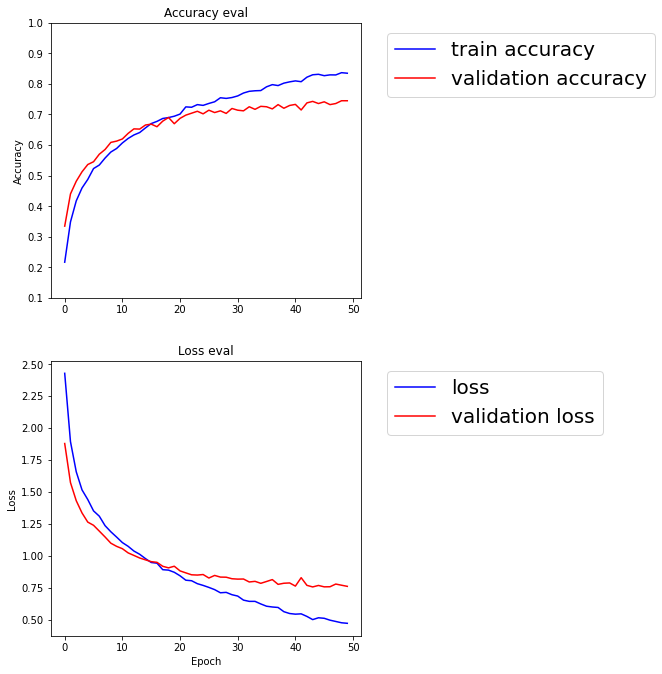

In [25]:
plot_history(history)

# Evaluating Model

In [18]:
#Evalution model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)
print(f'Test Accuracy: {test_acc}')

75/75 - 1s - loss: 0.7102 - accuracy: 0.7622
Test Accuracy: 0.7622259855270386


In [19]:
genres = encoder.inverse_transform(np.unique(targets))
genres

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [20]:
#Classification Report
predictions = model.predict(X_test)
predicted_indexes= np.argmax(predictions, axis=1)
print(classification_report(y_test, predicted_indexes,target_names = genres))

              precision    recall  f1-score   support

       blues       0.77      0.84      0.81       245
   classical       0.90      0.96      0.93       243
     country       0.73      0.59      0.65       257
       disco       0.69      0.70      0.69       241
      hiphop       0.76      0.73      0.75       227
        jazz       0.81      0.85      0.83       225
       metal       0.88      0.90      0.89       251
         pop       0.74      0.87      0.80       216
      reggae       0.71      0.67      0.69       224
        rock       0.59      0.52      0.55       243

    accuracy                           0.76      2372
   macro avg       0.76      0.76      0.76      2372
weighted avg       0.76      0.76      0.76      2372



In [21]:
cf = confusion_matrix(y_test, predicted_indexes)
cf

array([[207,   0,   8,   2,   2,   7,   9,   1,   4,   5],
       [  1, 234,   3,   0,   0,   3,   0,   0,   1,   1],
       [ 17,   5, 151,   7,   1,  11,   4,   9,  10,  42],
       [  2,   1,   8, 168,  12,   1,   5,  18,  15,  11],
       [  2,   1,   1,  18, 166,   4,   4,  13,  17,   1],
       [  9,  15,   4,   1,   1, 192,   1,   0,   0,   2],
       [  4,   0,   3,   2,   1,   0, 225,   0,   1,  15],
       [  0,   1,   4,   6,   7,   2,   0, 188,   3,   5],
       [  5,   1,   6,  21,  20,   2,   0,  11, 150,   8],
       [ 22,   2,  19,  19,   7,  15,   9,  14,   9, 127]])

In [22]:
cf.astype(np.float).sum(axis=1)

array([245., 243., 257., 241., 227., 225., 251., 216., 224., 243.])

In [23]:
n_cf_matrix = cf / cf.astype(np.float).sum(axis=1)
print(np.round(n_cf_matrix, 3))

[[0.845 0.    0.031 0.008 0.009 0.031 0.036 0.005 0.018 0.021]
 [0.004 0.963 0.012 0.    0.    0.013 0.    0.    0.004 0.004]
 [0.069 0.021 0.588 0.029 0.004 0.049 0.016 0.042 0.045 0.173]
 [0.008 0.004 0.031 0.697 0.053 0.004 0.02  0.083 0.067 0.045]
 [0.008 0.004 0.004 0.075 0.731 0.018 0.016 0.06  0.076 0.004]
 [0.037 0.062 0.016 0.004 0.004 0.853 0.004 0.    0.    0.008]
 [0.016 0.    0.012 0.008 0.004 0.    0.896 0.    0.004 0.062]
 [0.    0.004 0.016 0.025 0.031 0.009 0.    0.87  0.013 0.021]
 [0.02  0.004 0.023 0.087 0.088 0.009 0.    0.051 0.67  0.033]
 [0.09  0.008 0.074 0.079 0.031 0.067 0.036 0.065 0.04  0.523]]


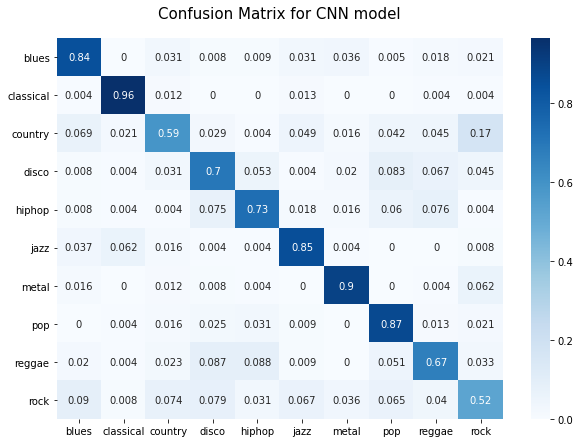

In [26]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(np.round(n_cf_matrix, 3), 
            annot=True,
            cmap='Blues',
            xticklabels = genres,
            yticklabels = genres)
plt.title('Confusion Matrix for CNN model',pad=20, fontdict={
    'fontsize':15
})
plt.savefig('Confusion_Matrix_for_CNN')

#Saving CNN Model

In [27]:
import pickle 
import os

In [28]:
# model_path = os.path.join(os.getcwd(), 'drive/Sub_Data')
# cnn_model = keras.models.load_model(model_path) 

In [29]:
model.save('CNN_model_mfcc13_G.h5')

#Making Predictions

In [30]:
def make_prediction(model, X, y):
    #adding a dimension to input data since model.predict() expects a 4d array as input
    X_to_predict= np.expand_dims(X,0)
    # inputs, targets = process_df(df)
    # encoder = LabelEncoder()
    # targets = encoder.fit_transform(targets)

    #perfrom predicition
    prediction = model.predict(X_to_predict)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_output = encoder.inverse_transform([predicted_index])[0]
    print(f'Original Label: {encoder.inverse_transform([y_to_predict])[0]} \n Predicted Output: {predicted_output}')
    return predicted_output
    #get index with ma 

In [31]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predicted_output = make_prediction(model, X_to_predict, y_to_predict)

Original Label: jazz 
 Predicted Output: classical


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[600]
y_to_predict = y_test[600]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: metal 
 Predicted Output: metal


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'metal'

In [33]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[-1]
y_to_predict = y_test[-1]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: reggae 
 Predicted Output: disco


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'disco'

In [34]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[232]
y_to_predict = y_test[232]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: classical 
 Predicted Output: classical


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'classical'

In [35]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[1948]
y_to_predict = y_test[1948]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: metal 
 Predicted Output: metal


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'metal'

In [36]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[666]
y_to_predict = y_test[666]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: country 
 Predicted Output: country


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'country'